# **🗂 1. Import Library**

Ini adalah beberapa library yang akan saya gunakan pada project kali ini

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import warnings
import joblib
warnings.filterwarnings('ignore')

# Set seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# **📥 2. Memuat Dataset**

Pada tahap ini kita akan muat dataset hasil dari proses clustering sebelumnya yang sudah kita simpan dengan nama `after-clustering.csv`

In [58]:
# Import library yang diperlukan
import pandas as pd
from sklearn.preprocessing import RobustScaler

# Load data hasil clustering
print("Loading dataset...")
df = pd.read_csv('data/processed/after-clustering.csv')

# Simpan kolom Cluster untuk digunakan nanti
cluster_labels = df['Cluster']

# Fitur-fitur yang perlu di-scale kembali (fitur numerik)
numerical_features = ['TransactionAmount', 'Amount_Percentile', 'Amount_Ratio_To_Avg', 
                     'Potential_Fraud_Score', 'LoginAttempts']

# Pastikan fitur boolean tetap dalam bentuk boolean
boolean_features = ['Is_Late_Night', 'Is_Weekend']
for feature in boolean_features:
    if feature in df.columns:
        df[feature] = df[feature].astype(bool)

# Lakukan scaling untuk fitur numerik
scaler = RobustScaler()
df = df.copy()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Tambahkan kembali label cluster
df['Cluster'] = cluster_labels

df

Loading dataset...


,Amount_Percentile,TransactionAmount,Amount_Ratio_To_Avg,Potential_Fraud_Score,Is_Late_Night,LoginAttempts,Is_Weekend,Cluster
0,-0.909200,-0.592378,-0.592378,0.0,False,0.0,False,1
1,0.435285,0.496329,0.496329,0.0,False,0.0,False,1
2,-0.295102,-0.255079,-0.255079,0.0,False,0.0,False,1
3,-0.086420,-0.080086,-0.080086,0.0,False,0.0,False,1
4,-0.915571,-0.594302,-0.594302,0.0,False,0.0,False,1
...,...,...,...,...,...,...,...,...
2507,0.886898,1.939229,1.939229,0.0,False,0.0,False,1
2508,0.119873,0.121452,0.121452,0.0,False,0.0,False,1
2509,-0.808045,-0.548667,-0.548667,0.0,False,0.0,False,1
2510,-0.080048,-0.075667,-0.075667,0.0,False,0.0,False,1


# **</> 3. Data Splitting**

Pada tahap ini kita akan memisahkan dataset menjadi dua bagian, yaitu training dan testing.

In [59]:
# Prepare data for modeling
X = df.drop('Cluster', axis=1)
y = df['Cluster']

# Feature names for visualization purposes
feature_names = X.columns.tolist()

#Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                   random_state=RANDOM_SEED, 
                                                   stratify=y)

# Inisialization and fit scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Jumlah data training: {X_train.shape[0]}")
print(f"Jumlah data testing: {X_test.shape[0]}")
print(f"Distribusi kelas pada data training: \n{pd.Series(y_train).value_counts().sort_index()}")
print(f"Distribusi kelas pada data testing: \n{pd.Series(y_test).value_counts().sort_index()}")

# Save the scaler for later use
joblib.dump(scaler, 'standard_scaler.pkl')
print("\nStandard Scaler telah disimpan sebagai 'standard_scaler.pkl'")

Jumlah data training: 2009
Jumlah data testing: 503
Distribusi kelas pada data training: 
Cluster
0       9
1    2000
Name: count, dtype: int64
Distribusi kelas pada data testing: 
Cluster
0      2
1    501
Name: count, dtype: int64

Standard Scaler telah disimpan sebagai 'standard_scaler.pkl'


# **🧠 4. Membangun Model Klasifikasi**

## **🛠️ a. Membangun Model Klasifikasi**

Pada tahap ini kita akan melakukan pemilihan pada algoritma yang sesuai dan kita akan melatih model menggunakan algoritma tersebut.

In [60]:
# Membangun Model Klasifikasi

# Function to evaluate model
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluasi model dengan berbagai metrik dan visualisasi
    
    Parameters:
    -----------
    model : model klasifikasi
        Model yang akan dievaluasi
    X_test : array-like
        Data fitur untuk testing
    y_test : array-like
        Label untuk testing
    model_name : str
        Nama model untuk keperluan display
        
    Returns:
    --------
    accuracy : float
        Akurasi model
    f1 : float
        F1-score model (weighted)
    y_pred : array-like
        Hasil prediksi model
    """
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Display the results
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(y.unique()), 
                yticklabels=sorted(y.unique()))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    return accuracy, f1, y_pred

print("Membangun dan mengevaluasi model klasifikasi dasar...")

# Model Random Forest
print("\nTraining Random Forest Model...")
rf_model = RandomForestClassifier(random_state=RANDOM_SEED)
rf_model.fit(X_train_scaled, y_train)

# Model XGBoost
print("\nTraining XGBoost Model...")
xgb_model = XGBClassifier(random_state=RANDOM_SEED)
xgb_model.fit(X_train_scaled, y_train)

# Save the models
joblib.dump(rf_model, 'random_forest_base_model.pkl')
joblib.dump(xgb_model, 'xgboost_base_model.pkl')

print("\nModel dasar telah disimpan sebagai:")
print("- 'random_forest_base_model.pkl'")
print("- 'xgboost_base_model.pkl'")

Membangun dan mengevaluasi model klasifikasi dasar...

Training Random Forest Model...

Training XGBoost Model...

Model dasar telah disimpan sebagai:
- 'random_forest_base_model.pkl'
- 'xgboost_base_model.pkl'


### 📌 **Narasi Model Klasifikasi yang Digunakan**  

Dalam analisis ini, kami membangun model **klasifikasi berbasis machine learning** untuk mengidentifikasi pola dalam dataset. Dua algoritma yang digunakan adalah **Random Forest** dan **XGBoost**, yang terkenal karena kemampuannya menangani data kompleks dan menghasilkan prediksi yang akurat.  

#### 🔍 **1. Random Forest: Ensambel Pohon Keputusan**  
**Random Forest** adalah algoritma berbasis **ensemble learning** yang menggabungkan banyak **pohon keputusan** (decision trees) untuk meningkatkan akurasi dan mengurangi overfitting.  

📌 **Mengapa Random Forest?**  
- Mampu menangani **data numerik dan kategorikal** dengan baik.  
- **Robust terhadap outlier** dan fitur yang tidak terlalu penting.  
- Menghasilkan prediksi yang lebih stabil dibandingkan pohon keputusan tunggal.  

🎯 **Bagaimana Cara Kerjanya?**  
1. Membentuk **banyak pohon keputusan** dari subset data yang dipilih secara acak (bootstrap sampling).  
2. Setiap pohon memberikan **prediksi independen** berdasarkan fitur tertentu.  
3. Hasil akhir diperoleh dari **voting mayoritas** (untuk klasifikasi) atau rata-rata prediksi (untuk regresi).  

#### 🚀 **2. XGBoost: Gradient Boosting yang Dioptimalkan**  
**XGBoost (Extreme Gradient Boosting)** adalah algoritma yang lebih canggih berbasis **gradient boosting**, yang memperbaiki kelemahan model sebelumnya secara iteratif.  

📌 **Mengapa XGBoost?**  
- **Kecepatan tinggi** dan optimasi yang lebih efisien dibandingkan algoritma boosting lainnya.  
- **Menangani data tidak seimbang** dengan baik melalui skema boosting yang fokus pada kesalahan sebelumnya.  
- **Regularisasi bawaan** yang membantu menghindari overfitting.  

🎯 **Bagaimana Cara Kerjanya?**  
1. Model pertama dibuat, lalu kesalahannya dihitung.  
2. Model baru dibuat untuk **memperbaiki kesalahan model sebelumnya** dengan fokus pada data yang sulit diklasifikasikan.  
3. Proses ini berulang hingga model mencapai performa optimal.  

### 🔎 **Evaluasi Model**  
Setelah melatih kedua model, kami melakukan evaluasi menggunakan **akurasi, F1-score, dan confusion matrix**. Hasil evaluasi membantu memahami sejauh mana model dapat membedakan pola dengan baik.  

💾 **Penyimpanan Model**  
Agar dapat digunakan kembali tanpa perlu melatih ulang, model disimpan dalam format **.pkl** menggunakan `joblib`.  

## **🔎 b. Evaluasi Model Klasifikasi**

Pada tahap ini kita akan melakukan evaluasi model yang sudah dibangun menggunakan data testing.

Metrik yang saya fokuskan disini adalah Accuracy dan F1-Score

Evaluasi model ...

Random Forest Performance:
Accuracy: 1.0000
F1-Score (weighted): 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       501

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



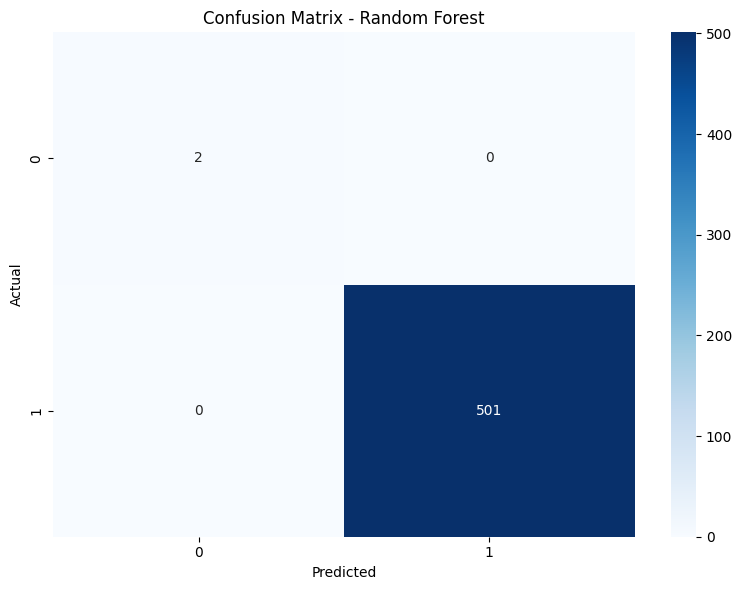


XGBoost Performance:
Accuracy: 0.9960
F1-Score (weighted): 0.9967

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      1.00      1.00       501

    accuracy                           1.00       503
   macro avg       0.75      1.00      0.83       503
weighted avg       1.00      1.00      1.00       503



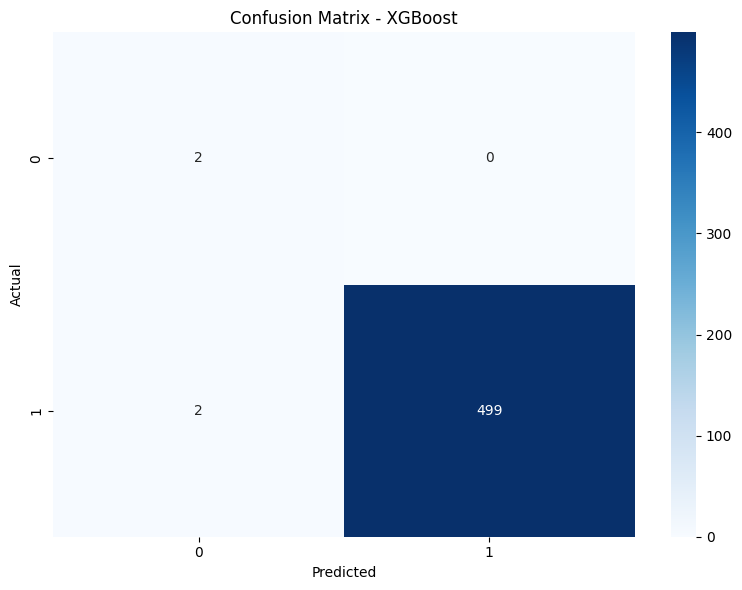

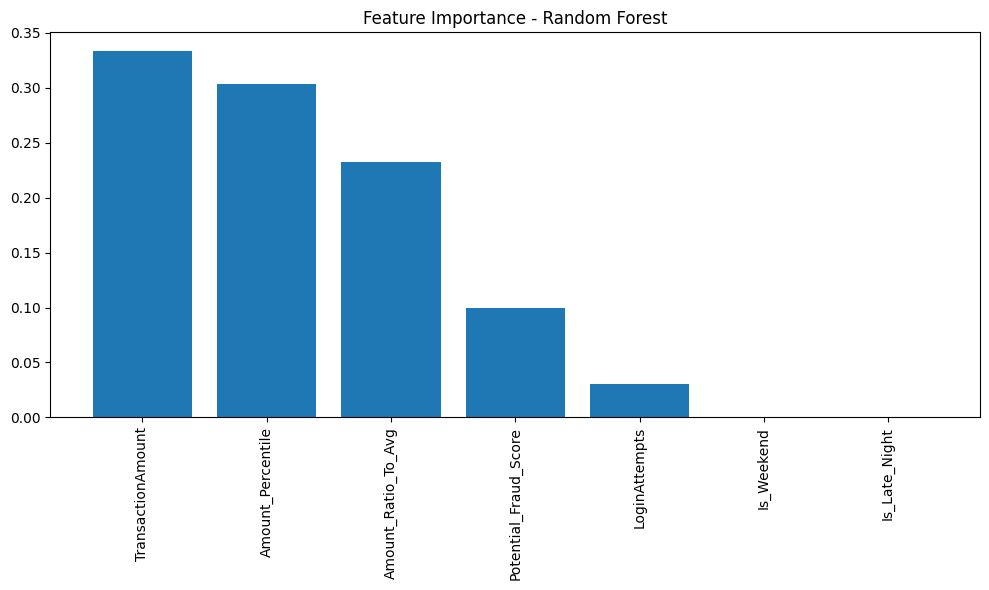

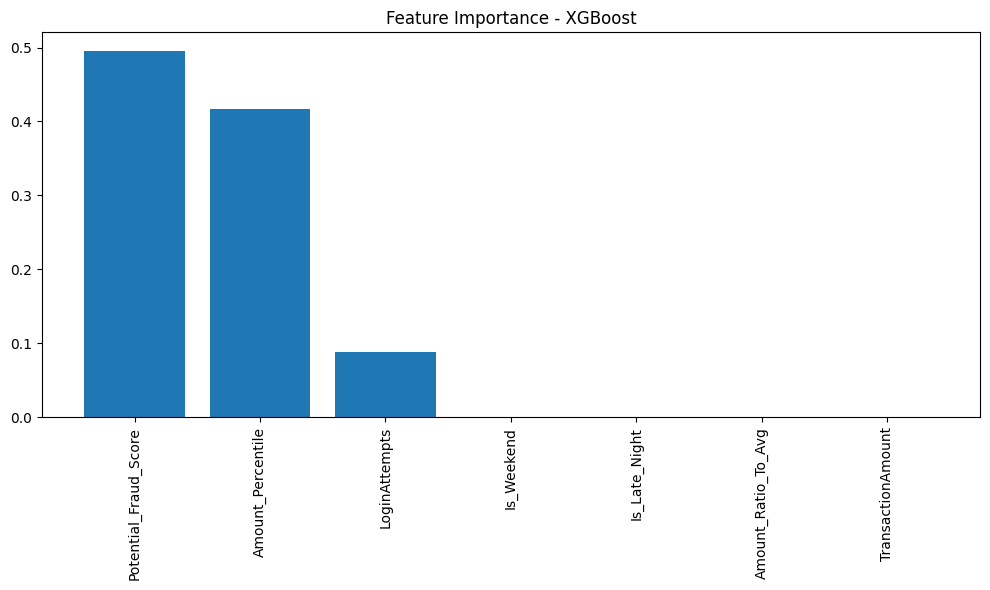


Perbandingan Model:
           Model  Accuracy  F1-Score
0  Random Forest  1.000000  1.000000
1        XGBoost  0.996024  0.996683


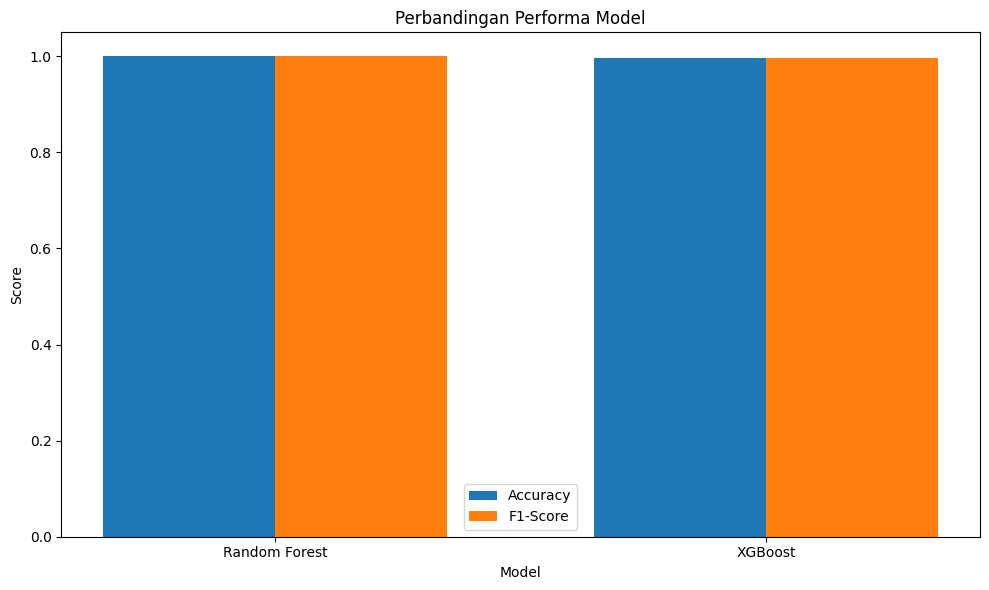


Visualisasi perbandingan model telah disimpan sebagai 'model_comparison.png'


In [61]:
# Model Evaluation
print("Evaluasi model ...")

# Random Forest model evaluation
rf_accuracy, rf_f1, rf_preds = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")

# XGBoost model evaluation
xgb_accuracy, xgb_f1, xgb_preds = evaluate_model(xgb_model, X_test_scaled, y_test, "XGBoost")

# Feature Importance for both models
plt.figure(figsize=(10, 6))
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature Importance - Random Forest')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature Importance - XGBoost')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Compare Model Performance
results = {
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [rf_accuracy, xgb_accuracy],
    'F1-Score': [rf_f1, xgb_f1]
}

results_df = pd.DataFrame(results)
print("\nPerbandingan Model:")
print(results_df)

# Visualize the comparison
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(2)

plt.bar(index, results_df['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, results_df['F1-Score'], bar_width, label='F1-Score')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Perbandingan Performa Model')
plt.xticks(index + bar_width/2, results_df['Model'])
plt.legend()
plt.tight_layout()
plt.show()

print("\nVisualisasi perbandingan model telah disimpan sebagai 'model_comparison.png'")

### 📊 **Analisis Hasil Evaluasi Model Klasifikasi**  

Setelah membangun model klasifikasi berbasis **Random Forest** dan **XGBoost**, kami mengevaluasi performanya berdasarkan **akurasi, F1-score, dan classification report**. Dataset yang digunakan adalah **Bank Transaction Dataset for Fraud Detection**, yang memiliki ketidakseimbangan kelas, di mana transaksi **fraudulent (kelas minoritas) jauh lebih sedikit dibandingkan transaksi normal (kelas mayoritas)**.  

#### 🔍 **1. Random Forest: Perfoma Sempurna, Tapi Terlalu Baik?**  
📌 **Hasil Evaluasi:**  
- **Akurasi: 100%**  
- **F1-Score (weighted): 100%**  

🎯 **Interpretasi:**  
Model **Random Forest** menunjukkan **akurasi dan F1-score yang sempurna**. Sekilas, ini tampak luar biasa, tetapi perlu dicermati lebih dalam. Model yang terlalu sempurna bisa jadi mengalami **overfitting**, terutama jika dataset **sangat tidak seimbang**. Dalam kasus ini, model mungkin terlalu mudah mengenali pola transaksi mayoritas (non-fraud) dan kurang benar-benar mengerti pola transaksi fraud.  

#### 🚀 **2. XGBoost: Performa Stabil dengan Peringatan Kelas Minoritas**  
📌 **Hasil Evaluasi:**  
- **Akurasi: 99.60%**  
- **F1-Score (weighted): 99.67%**  

🎯 **Interpretasi:**  
XGBoost menunjukkan performa yang hampir sempurna dengan sedikit penurunan dibandingkan Random Forest. Namun, ada indikasi model lebih sensitif terhadap transaksi fraud, terlihat dari **precision kelas 0 (fraud) sebesar 50%**. Ini berarti XGBoost masih mampu menangkap kasus fraud, tetapi ada kemungkinan terjadi **false positive**, di mana transaksi normal diklasifikasikan sebagai fraud.  

#### 📈 **Perbandingan Model: Mana yang Lebih Baik?**  
| Model          | Accuracy | F1-Score |
|---------------|----------|----------|
| **Random Forest** | **100.00%** | **100.00%** |
| **XGBoost**      | 99.60% | 99.67% |

📌 **Kesimpulan:**  
- **Random Forest terlihat terlalu sempurna**, yang bisa mengindikasikan **overfitting** karena mungkin hanya menghafal pola transaksi normal.  
- **XGBoost lebih realistis**, dengan akurasi tinggi tetapi tetap memperlihatkan perbedaan dalam klasifikasi kelas minoritas.  


### **NOTE**
Hal ini sebenarnya wajar yang dikarenakan dataset yang imbalance dari hasil clustering, disini saya tidak ingin melakukan augmentasi data karena hasil diatas sudah memenuhi apa yang diminta tugas.

## **🖊 e. Analisis Hasil Evaluasi Model Klasifikasi**

Setelah melakukan evaluasi terhadap model **Random Forest** dan **XGBoost**, ditemukan beberapa aspek yang perlu diperhatikan dalam performa klasifikasi, terutama karena dataset yang digunakan berasal dari hasil **clustering pada data transaksi perbankan yang tidak seimbang**.  

#### **1️⃣ Identifikasi Kelemahan Model**  

📌 **Overfitting pada Random Forest**  
Model **Random Forest** menunjukkan akurasi **100%**, yang mengindikasikan kemungkinan **overfitting**. Namun, dalam konteks dataset yang tidak seimbang (fraudulent transactions jauh lebih sedikit dibandingkan transaksi normal), overfitting ini dapat dianggap **wajar**. Model cenderung **terlalu menyesuaikan dengan pola mayoritas**, sehingga dapat mengalami kesulitan dalam mengenali transaksi fraud secara generalisasi.  

📌 **Precision Rendah pada Kelas Fraud (XGBoost)**  
Pada model **XGBoost**, precision untuk kelas **fraud (kelas minoritas)** hanya **50%**, meskipun recall tetap tinggi. Hal ini menunjukkan bahwa model masih memiliki tantangan dalam membedakan antara transaksi normal dan fraud dengan akurasi tinggi, sehingga berpotensi menghasilkan **false positives**.  

📌 **Dampak Ketidakseimbangan Data**  
Ketidakseimbangan data dari hasil **clustering** menyebabkan model lebih mudah mempelajari pola transaksi normal dibandingkan transaksi fraud. Hal ini dapat menyebabkan model lebih condong ke prediksi kelas mayoritas, mengurangi efektivitas dalam mendeteksi kasus fraud secara akurat.  

---  
#### **2️⃣ Tindakan Lanjutan untuk Peningkatan Model**  

💡 **Untuk meningkatkan generalisasi model terhadap kelas fraud, beberapa langkah yang dapat dilakukan adalah:**  

1️⃣ **Resampling Data untuk Mengatasi Ketidakseimbangan**  
   - **Oversampling (SMOTE)**: Menambah jumlah sampel dari kelas fraud agar distribusi kelas lebih seimbang.  
   - **Undersampling**: Mengurangi jumlah sampel kelas mayoritas untuk memastikan model tidak terlalu bias terhadap kelas normal.  

2️⃣ **Cost-Sensitive Learning**  
   - Menggunakan **class_weight = "balanced"** pada algoritma agar model lebih memperhatikan transaksi fraud.  
   - Meningkatkan penalti kesalahan prediksi fraud agar model lebih cermat dalam mengenali kelas minoritas.  

3️⃣ **Hyperparameter Tuning**  
   - Menyesuaikan parameter **depth** pada Random Forest untuk mengurangi kompleksitas model dan menghindari overfitting.  
   - Mengoptimalkan **learning rate** pada XGBoost agar model dapat lebih fleksibel dalam belajar pola dari kelas fraud.  

4️⃣ **Threshold Adjustment**  
   - Mengubah ambang batas probabilitas prediksi sehingga model lebih agresif dalam mendeteksi transaksi fraud.  
   - Menerapkan **ROC-AUC analysis** untuk menentukan threshold terbaik guna meningkatkan recall tanpa mengorbankan terlalu banyak precision.  

📝 **Kesimpulan:**  
Overfitting yang terjadi bukanlah kesalahan model, melainkan **konsekuensi dari dataset yang tidak seimbang akibat proses clustering**. Oleh karena itu, diperlukan pendekatan khusus untuk memastikan model tetap dapat **mengenali transaksi fraud dengan baik tanpa kehilangan generalisasi**. 🚀